# Tracking Objects in Videos

Importing Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

**Reading the data**

In [2]:
car1 = np.load('data/car1.npy')
car2 = np.load('data/car2.npy')
landing = np.load('data/landing.npy')

**car1.npy Details**

In [3]:
car1.shape

(480, 720, 261)

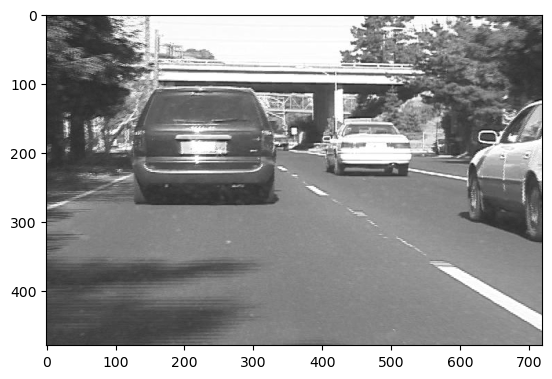

In [4]:
plt.imshow(car1[:,:,0], cmap='gray', vmin=0, vmax=255)

**car2.npy Details**

In [5]:
car2.shape

(240, 320, 415)

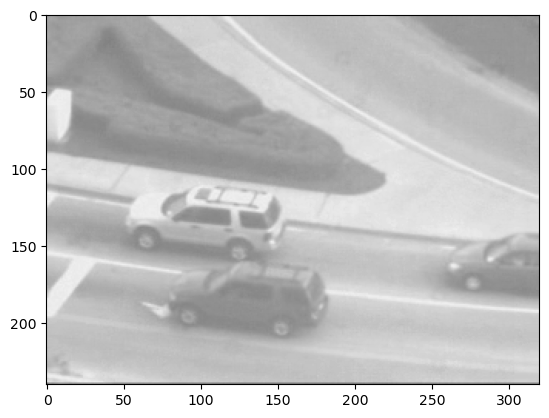

In [6]:
plt.imshow(car2[:,:,0], cmap='gray', vmin=0, vmax=255)

**landing.npy Details**

In [7]:
landing.shape

(1000, 1100, 50)

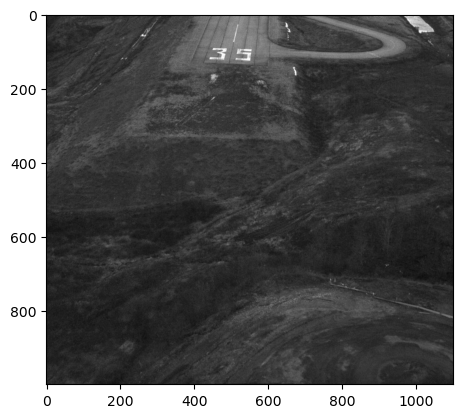

In [8]:
plt.imshow(landing[:,:,0], cmap='gray', vmin=0, vmax=255)

## Lucas-Kanade Tracker Implementation

**Auxiliary Functions**

In [9]:
def convert_to_video(images, video_name, fps=24):
    height, width, frames = images.shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height), 0)
    for i in range(frames):
        video.write(images[:, :, i])
    cv2.destroyAllWindows()
    video.release()

In [10]:
def jacobian(x_shape, y_shape):
    ones = np.ones((y_shape, x_shape))
    zeros = np.zeros((y_shape, x_shape))
    x, y = np.meshgrid(np.array(range(x_shape)), np.array(range(y_shape))) 
    row1 = np.stack((x, zeros, y, zeros, ones, zeros), axis=2)
    row2 = np.stack((zeros, x, zeros, y, zeros, ones), axis=2)
    return np.stack((row1, row2), axis=2) 

In [11]:
def crop(image, bounding_box):
    x, y, w, h = bounding_box
    return image[y:y+h, x:x+w]

In [12]:
def compute_gradients(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    return grad_x, grad_y

In [13]:
def new_bounding_box(x, y, w, h, w_p):
    u_l = np.round(np.dot(w_p, np.array([x, y, 1]))).astype(int)
    l_r = np.round(np.dot(w_p, np.array([x+w, y+h, 1]))).astype(int)
    x, y, w, h = u_l[0], u_l[1], l_r[0] - u_l[0], l_r[1] - u_l[1]
    return (x, y, w, h)

In [14]:
def draw_bounding_box(image, x, y, w, h):
    return cv2.rectangle(image.copy(), (x, y), (x+w, y+h), (0, 0, 255), 2)

**Tracker Function**

In [26]:
def lucas_kanade_tracker(frame1, frame2, bounding_box, p, num_iters=100, threshold=0.0015):
    template = crop(frame1, bounding_box)
    w, h = template.shape
    
    # Pre-evaluate Jacobian
    delW_delp = jacobian(h, w)
    
    for i in range(num_iters):
        # Warp Image
        w_p = np.array([[1+p[0], p[2], p[4]], [p[1], 1+p[3], p[5]]])
        warped_image = crop(cv2.warpAffine(frame2, w_p, (frame2.shape[1],frame2.shape[0])), bounding_box)

        # Compute error image
        b = template.astype(int) - warped_image.astype(int)
    
        # Calculate warp gradient of image
        grad_x, grad_y = compute_gradients(frame2)
        grad_x = crop(cv2.warpAffine(grad_x, w_p, (frame2.shape[1],frame2.shape[0])), bounding_box)
        grad_y = crop(cv2.warpAffine(grad_y, w_p, (frame2.shape[1],frame2.shape[0])), bounding_box)
        grad = np.expand_dims((np.stack((grad_x, grad_y), axis=2)), axis=2)

        # Compute Hessian matrix
        A = np.matmul(grad, delW_delp)
        A_T = np.transpose(A, (0, 1, 3, 2))
        H = np.matmul(A_T, A).sum((0,1))
        H_inv = np.linalg.pinv(H)

        # Compute delta_p
        delta_p = np.matmul(H_inv, (A_T * b.reshape((w, h, 1, 1))).sum((0,1))).reshape(-1)
        
        # Update parameters
        p += delta_p
        
        if np.linalg.norm(delta_p) < threshold:
            break

    return p

In [31]:
def track_object(frame_series, initial_bb):
    height, width, frames = frame_series.shape
    bb = initial_bb
    frames_tracked = [draw_bounding_box(frame_series[:,:,0], *bb)]
    for i in range(1, frames):
        p = np.zeros(6,)
        p = lucas_kanade_tracker(frame_series[:,:,i-1], frame_series[:,:,i], bb, p)
        w_p = np.array([[p[0]+1, p[2], p[4]], [p[1], p[3]+1, p[5]]])
        bb = new_bounding_box(*bb, w_p)
        frames_tracked.append(draw_bounding_box(frame_series[:,:,i], *bb))
    return np.stack(frames_tracked, axis=2)

**Tracking the objects...**

In [32]:
car1_tracked = track_object(car1, (125, 100, 210, 180))
convert_to_video(car1_tracked, "car1_tracked.mp4")

In [33]:
car2_tracked = track_object(car2, (50, 107, 110, 57))
convert_to_video(car2_tracked, "car2_tracked.mp4")

In [34]:
landing_tracked = track_object(landing, (435, 85, 125, 45))
convert_to_video(landing_tracked, "landing_tracked.mp4")